*Unresolved Question*

1. Sampling - <br>
    → `Averaging Methods` - `Tree level smapling` <br>
    → `Random Forest` - `Node level sampling`
2. Size of each dataset used to train base models wrt each type after respective samppling <br>
    → The shape (rows and features) will be depend on the hyperparameters `max_samples` and `max_features`
3. Random Forest - <br>
    → Random Forest = Bagging + Feature Sampling (`node level`)
4. `oob_score` is the `accuracy` of model's prediction on that unseen data
5. How `boostrap_features` works? <br>
    → Decision Tree (Base Model) `does not automatically ignore a duplicated feature`. It treats each feature column as distinct, even if there are duplicate features and try to find the splitting criteria -> That base model might biased towards that duplicated feature
6. Since, bagging classificier will predict mejority classes as final result, that menas it follows `hard marging` approach and there is not hyperparameter for `soft voting`.
---

In [1]:
# Forming Dataset
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification

X, y = make_classification(
    n_samples=10000,
    n_features=10,
    n_informative=3,
    n_classes=3,
    n_clusters_per_class=2,
    random_state=42
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
pd.DataFrame(
    np.hstack((X_train, y_train.reshape(-1, 1))),
    columns=[f"Feature_{i}" for i in range(X_train.shape[1])] + ['Label']
).head(10)

,Feature_0,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,Feature_9,Label
0,-0.382465,-0.152885,-0.618781,0.125576,-2.023095,0.165369,-0.338198,0.184012,0.849690,-0.718394,1.0
1,-1.276547,0.698244,0.699993,0.747120,1.777280,0.646566,0.006382,-0.181671,-0.744670,-0.405203,1.0
2,-1.616938,0.805026,1.128663,0.300456,1.370398,-0.236073,0.426304,1.328295,-0.595304,0.258470,1.0
3,-1.472212,-1.553375,3.131300,-1.998042,1.654932,-1.727033,0.069709,-0.725907,-0.794475,-1.867260,2.0
4,-0.586952,1.342551,-1.066953,1.175936,-1.061292,-1.235062,-0.382656,-0.691801,0.478405,0.764093,0.0
5,-0.945772,-1.141879,-0.126700,1.006557,0.603722,0.604179,0.314358,-1.399799,-0.235268,-0.864205,1.0
6,-0.633441,1.567001,0.715463,-1.034336,-1.477380,1.158114,1.099696,-0.050831,0.574039,-0.758152,2.0
7,-0.044838,0.100926,-1.202517,2.285884,2.079372,0.450789,-1.167993,-0.902053,-0.795072,0.344221,1.0
8,0.146602,0.190195,-0.205420,0.775158,1.522893,-0.837432,0.747855,0.221569,-0.611133,1.517583,0.0
9,-0.909548,0.901173,-0.573685,0.941203,-0.748501,-0.816151,-0.260476,-0.549839,0.332547,-0.941421,1.0


### 1. Bagging (Bootstrap Aggregating)
*   **What it does:** **Samples training instances *with* replacement.**
*   **How it creates diversity:** Each base model is trained on a different **bootstrap sample** of the original training data. This means each sample is the same size as the original dataset, but some examples are duplicated and others are left out ("out-of-bag" samples).

In [2]:
# Building Model
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier

bg = BaggingClassifier(
    # Estimator parameters
    estimator=DecisionTreeClassifier(
        # Generally, Low Variance models were used - to reduce overall variance
        max_depth = 3,
        random_state = 42
    ),
    n_estimators=50, 

    # Size Manipulation parameters
    max_samples=0.75,
    max_features=1.0, # No feature sampling

    # Sampling (with / without) replacement parameters
    bootstrap=True, # Row Sampling with replacement - Bagging Charastristic
    bootstrap_features=False, # No feature sampling

    # Other parameters
    oob_score=True, # The observations which is not used for training in any of the base models - Out of bag estimation only available if bootstrap=True
    warm_start=False, # Trainig stated where it left off
    random_state=42,
    verbose=1
)

In [3]:
# Training the Model
bg.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.6s finished


,estimator,DecisionTreeC...ndom_state=42)
,n_estimators,50
,max_samples,0.75
,max_features,1.0
,bootstrap,True
,bootstrap_features,False
,oob_score,True
,warm_start,False
,n_jobs,None
,random_state,42
,verbose,1


In [4]:
# Configurations of a base estimator
bg.estimator_

,criterion,'gini'
,splitter,'best'
,max_depth,3
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


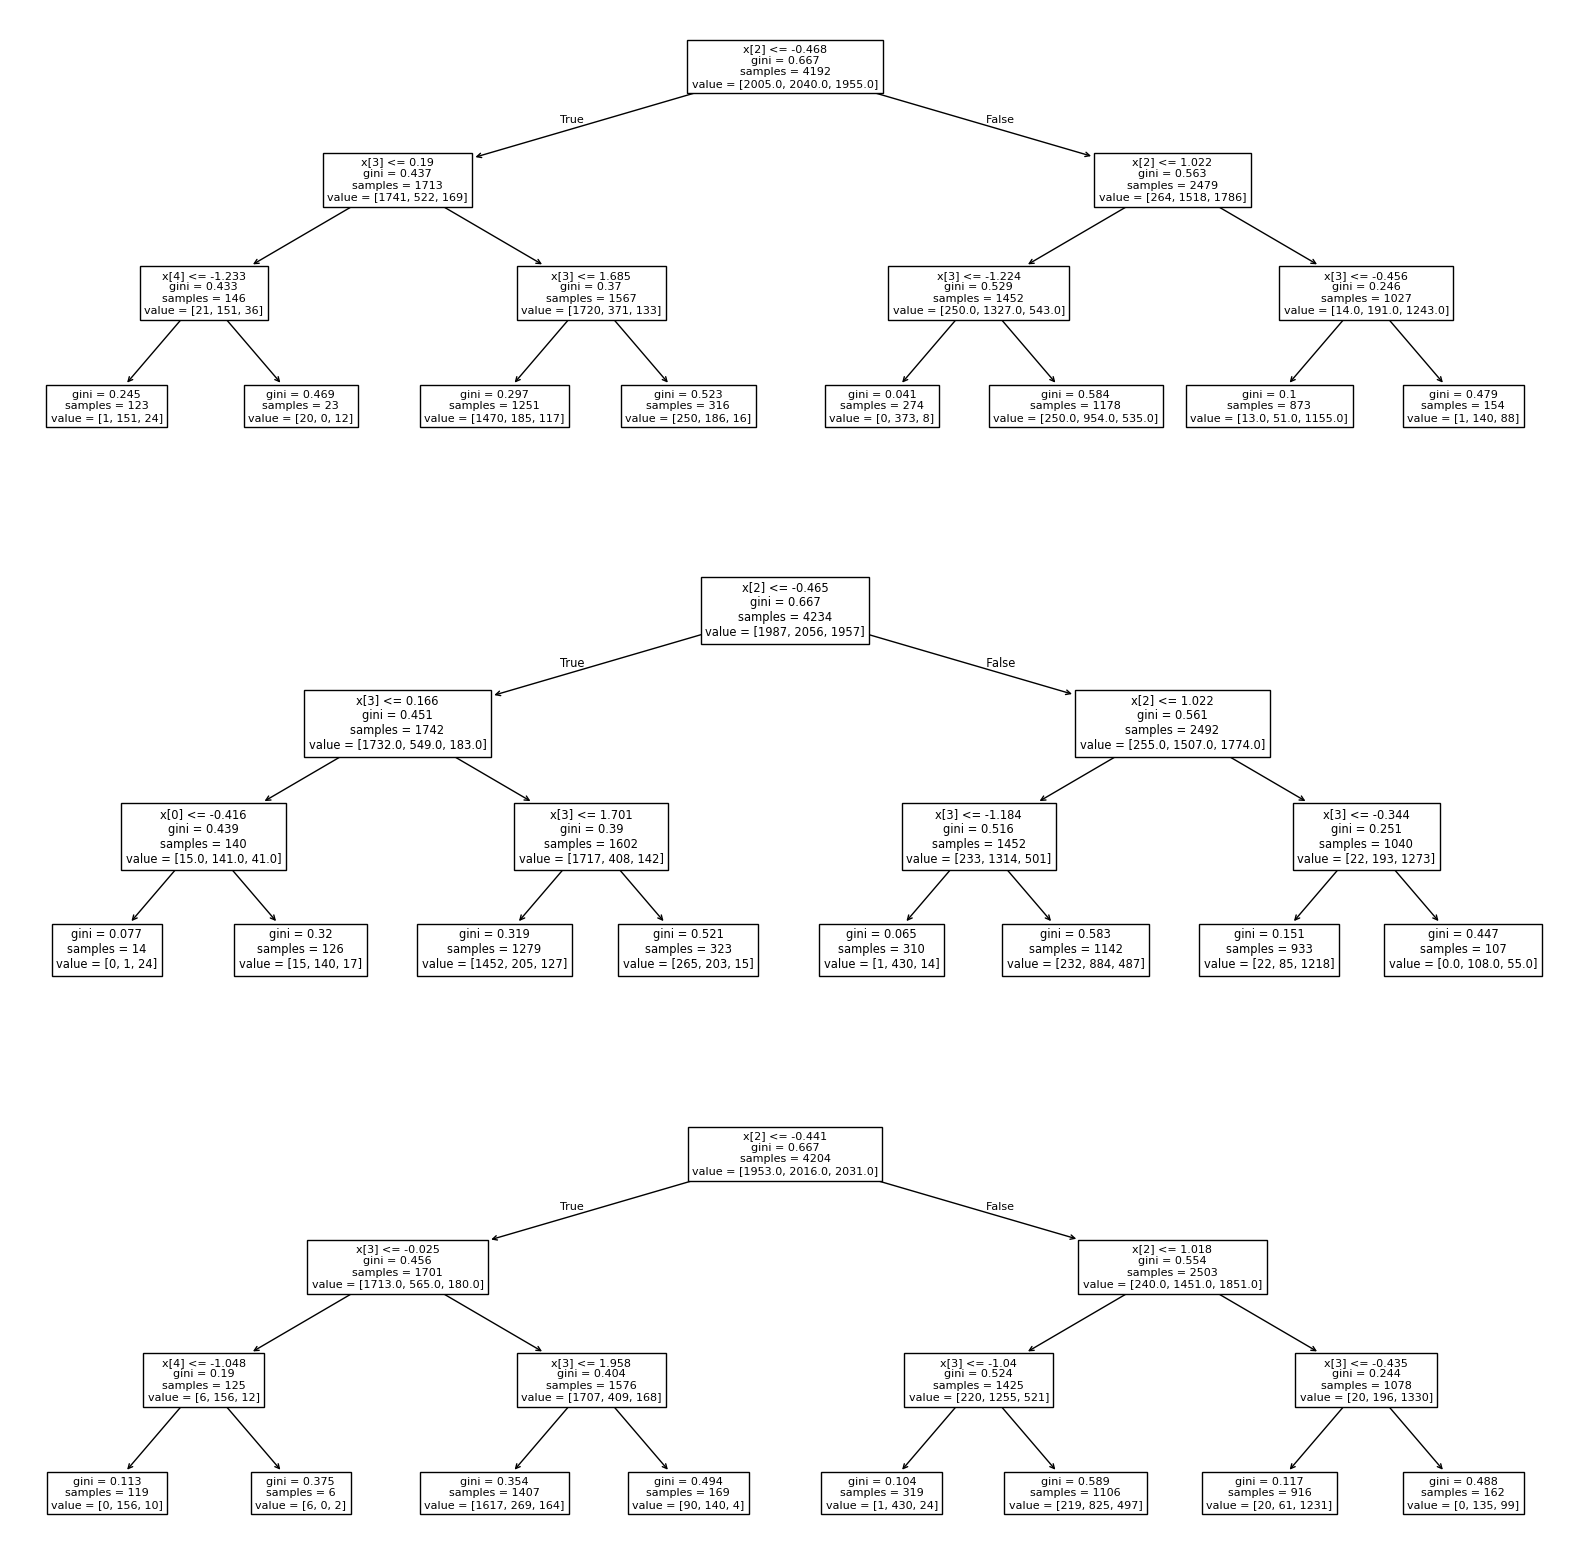

In [5]:
# Decision Tree for first three base estimators
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(20, 20))
for idx, estimator in enumerate(bg.estimators_):
    if idx >= 3:
        break
    plot_tree(estimator, ax = ax[idx])
plt.show()

In [6]:
# Checking whether observations replaced or not - should be replaced (Bagging)
f"Number of Duplicate rows used to train 1st base model: {len(bg.estimators_samples_[0]) - len(np.unique(bg.estimators_samples_[0]))}"

'Number of Duplicate rows used to train 1st base model: 1808'

In [7]:
# Checking whether features replaced or not - should not be replaced (Bagging)
f"Number of Duplicate features used to train 1st base model: {len(bg.estimators_features_[0]) - len(np.unique(bg.estimators_features_[0]))}"

'Number of Duplicate features used to train 1st base model: 0'

### Out-of-Bag Evaluation
- The `Out-of-Bag (OOB) score` is a performance metric for Ensemble models (Bagging and Random Forest), which provides an unbiased estimate of the model’s performance on unseen data. It is calculated using the samples that are not used in the training of the model, also known as out-of-bag (OOB) samples.
- It is statically proven that `37% data is not visited while doing sampling multiple times`<BR><br>
- so `oob_score` is the `accuracy` of model's prediction on that unseen data 

In [8]:
# The observations from traning set does not used to train the base models at all act as test data
bg.oob_score_

0.75025

In simple terms, `bg.oob_decision_function_` returns the **"report card" for your training data, but graded only by the trees that never saw them during training.**

### What is the "OOB Decision Function"?

The OOB decision function is a clever way to use your ensemble model to **validate itself without needing a separate validation set**.

Here's how it works:
1.  For a single data point (let's call it `X_i`), you find all the trees in the forest that were trained **without** `X_i` (i.e., the trees for which `X_i` was an "out-of-bag" sample).
2.  You take **only those trees** and let them vote on what class they think `X_i` belongs to. Since these trees never saw `X_i` during training, this vote is a form of an **unbiased test** for that data point.
3.  The `oob_decision_function_` collects the results of this vote for every single data point in your training set. (and do not average the probability, see the below example)

### What Does It Actually Return?

It returns an array where:
*   **Each row** corresponds to a data point in your original training set.
*   **Each column** corresponds to a class (e.g., Class 0, Class 1, Class 2).
*   **The value in each cell** is the **probability** that the data point belongs to that class, as calculated by the votes of its "out-of-bag" trees.

**For a binary classification problem, it might look like this:**

| | Prob(Class 0) | Prob(Class 1) | Final Prediction |
| :--- | :--- | :--- | :--- |
| **Data point 1** | 0.90 | 0.10 | Class 0 |
| **Data point 2** | 0.15 | 0.85 | Class 1 |
| **Data point 3** | 0.55 | 0.45 | Class 0 |

*   For Data point 1, 90% of the trees that never trained on it predicted it was **Class 0**.
*   For Data point 3, the vote was very close (55% vs. 45%), meaning the model is uncertain about this point.

### Simple Analogy: The Class Project

Imagine a class of 100 students (the "trees") working on a project.

*   The teacher gives each student a different random set of textbooks to study from (this is **bagging**).
*   For the final exam, the teacher has a brilliant idea. To grade a student's answer on a question, they ask **only the students who did NOT have the textbook that contained that question's answer**. This ensures the grade is fair and not based on memorization.
*   The `oob_decision_function_` is like the teacher's spreadsheet showing the final, fairly-assigned grade for every single question on the exam.

### Why is this Useful?

1.  **Free Validation Set:** You get an estimate of your model's accuracy (`oob_score_`) without having to sacrifice any of your data for a hold-out validation set. This is precious if you have a small dataset.
2.  **Identifies Uncertainty:** You can see which data points your model is very confident about (probabilities near 1.0 or 0.0) and which it struggles with (probabilities near 0.5).

### Important Note

You must have set `oob_score=True` when you created your Bagging classifier (`bg = BaggingClassifier(oob_score=True, ...)`) for the `oob_decision_function_` to be available. Otherwise, it won't exist.

In summary: `bg.oob_decision_function_` gives you the predicted probabilities for your training data, calculated in a honest way that helps prevent overfitting and gives you a free performance estimate.

In [9]:
bg.oob_decision_function_ # This attribute exists only when oob_score is True.

array([[0.3175868 , 0.45414   , 0.2282732 ],
       [0.14734329, 0.54388806, 0.30876865],
       [0.01862914, 0.62943946, 0.3519314 ],
       ...,
       [0.01629304, 0.05072033, 0.93298663],
       [0.01559882, 0.04795786, 0.93644332],
       [0.0731174 , 0.59663912, 0.33024348]], shape=(8000, 3))

In [10]:
# Model Evaluation
from sklearn.metrics import accuracy_score, f1_score
y_pred = bg.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1_score:", f1_score(y_test, y_pred, average="weighted"))

Accuracy: 0.737
F1_score: 0.7341494651325228


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


### 2. Pasting

*   **What it does:** **Samples training instances *without* replacement.**
*   **How it creates diversity:** Each base model is trained on a different random *subset* of the original training data. No data point is duplicated within a single subset.

In [11]:
pc = BaggingClassifier(
    # Estimator parameters
    estimator=DecisionTreeClassifier(
        # Generally, Low Variance models were used - to reduce overall variance
        max_depth = 3,
        random_state = 42
    ),
    n_estimators=50, 

    # Size Manipulation parameters
    max_samples=0.75,
    max_features=1.0, # No feature sampling

    # Sampling (with / without) replacement parameters
    bootstrap=False, # Row Sampling without replacement - (Pasting Charastristic)
    bootstrap_features=False, # No feature sampling

    # Other parameters
    oob_score=False, # Out of bag estimation only available if bootstrap=True
    warm_start=False, # Trainig stated where it left off
    random_state=42,
    verbose=1
)

In [12]:
# Training the Model
pc.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.3s finished


,estimator,DecisionTreeC...ndom_state=42)
,n_estimators,50
,max_samples,0.75
,max_features,1.0
,bootstrap,False
,bootstrap_features,False
,oob_score,False
,warm_start,False
,n_jobs,None
,random_state,42
,verbose,1


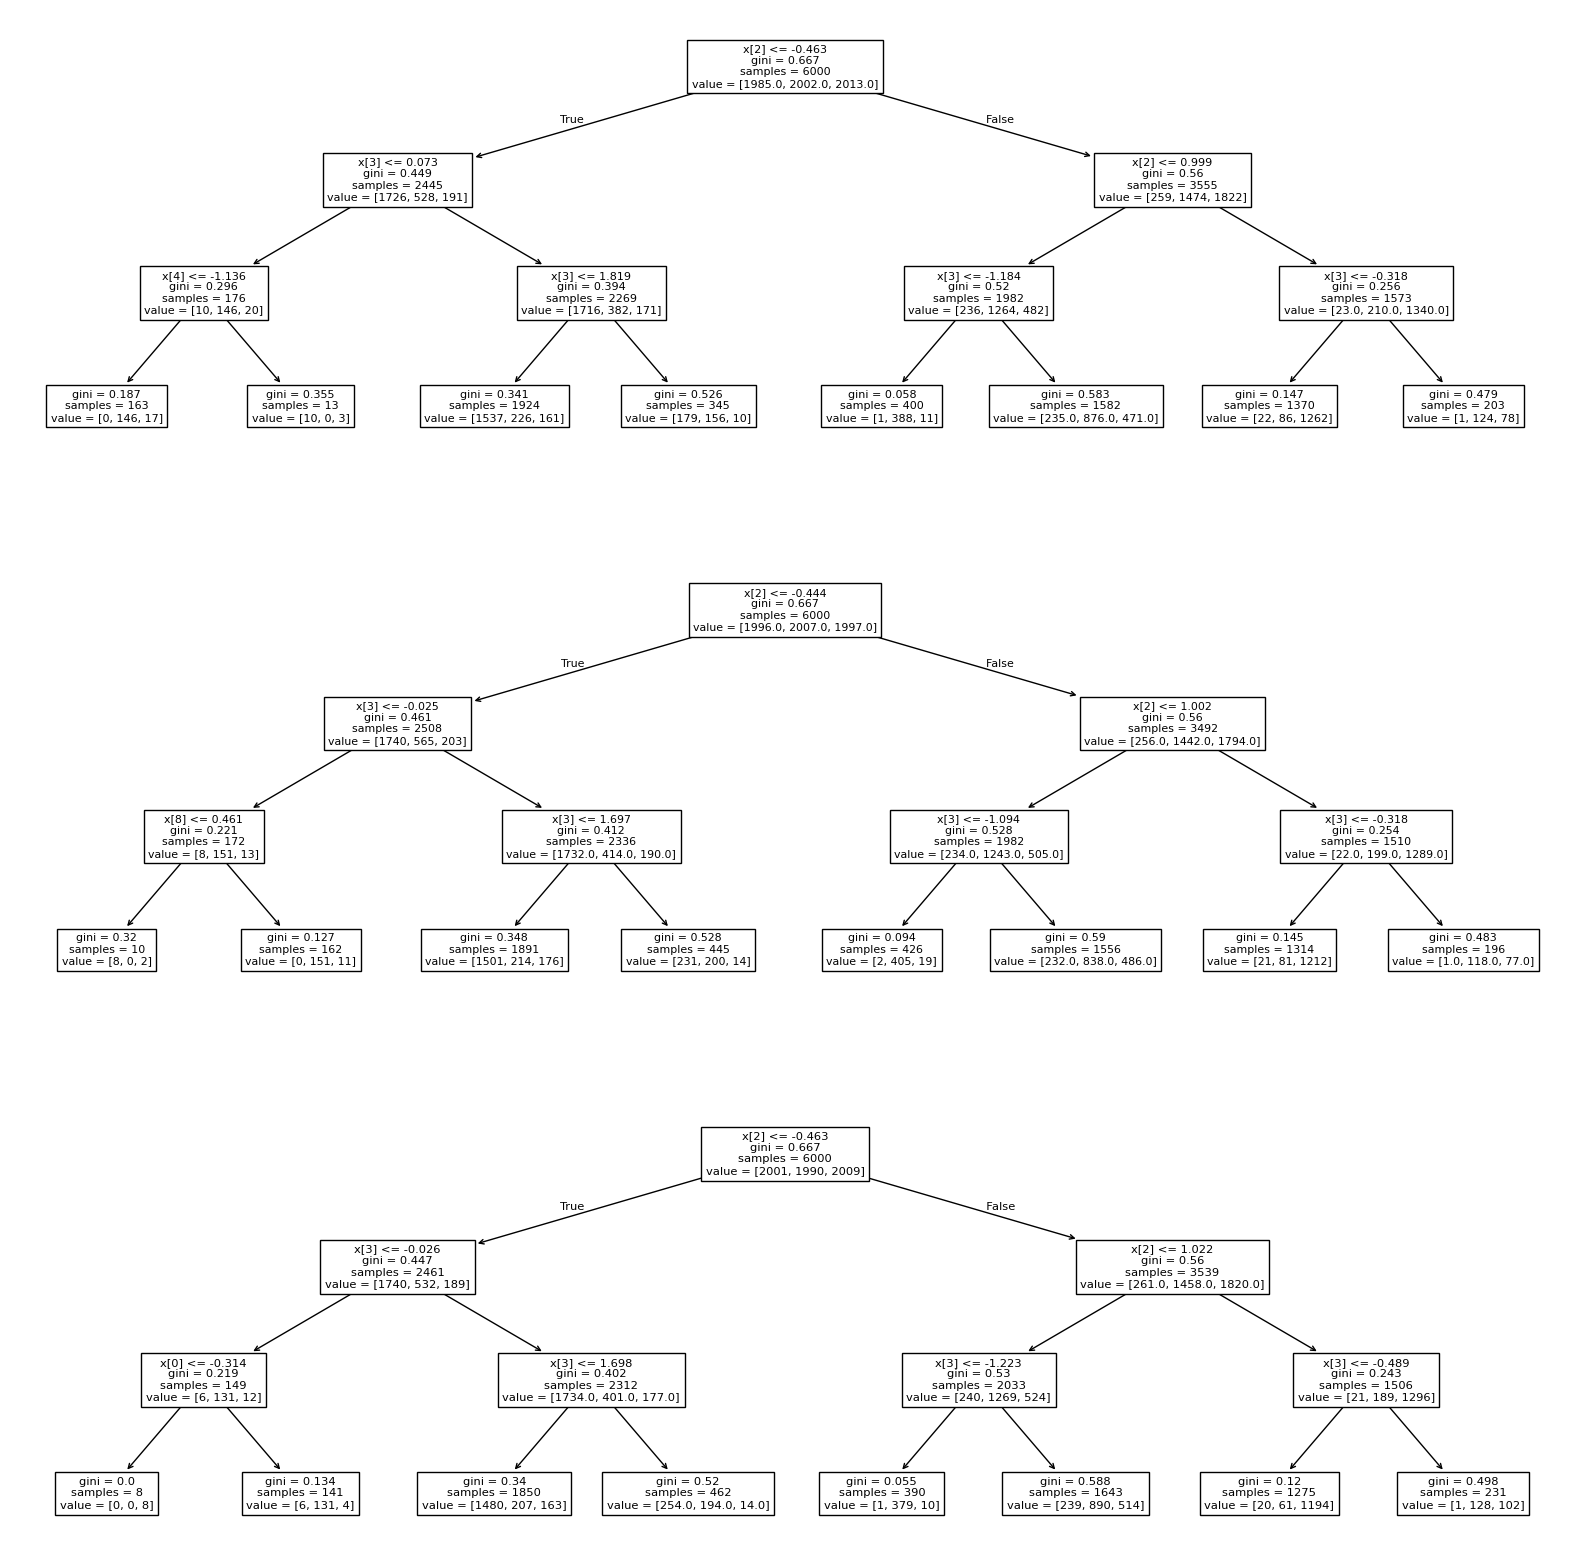

In [13]:
# Decision Tree for first three base estimators

fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(20, 20))
for idx, estimator in enumerate(pc.estimators_):
    if idx >= 3:
        break
    plot_tree(estimator, ax = ax[idx])
plt.show()

In [16]:
# Checking whether observations replaced or not - should not be replaced (Pasting)
f"Number of Duplicate rows used to train 1st base model: {len(pc.estimators_samples_[0]) - len(np.unique(pc.estimators_samples_[0]))}"

'Number of Duplicate rows used to train 1st base model: 0'

In [17]:
# Checking whether features replaced or not - should not be replaced (Pasting)
f"Number of Duplicate features used to train 1st base model: {len(pc.estimators_features_[0]) - len(np.unique(pc.estimators_features_[0]))}"

'Number of Duplicate features used to train 1st base model: 0'

In [18]:
# Evaluation
y_pred = pc.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1_score:", f1_score(y_test, y_pred, average="weighted"))

Accuracy: 0.736
F1_score: 0.7329079623474154


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


### 3. Random Subspaces

*   **What it does:** **Samples *features* (columns) *without* replacement.**
*   **How it creates diversity:** Each base model is trained on **all the training instances** but on a different random *subset of the features*.



In [19]:
rs = BaggingClassifier(
    # Estimator parameters
    estimator=DecisionTreeClassifier(
        # Generally, Low Variance models were used - to reduce overall variance
        max_depth = 3,
        random_state = 42
    ),
    n_estimators=50, 

    # Size Manipulation parameters
    max_samples=1.0, # No row sampling
    max_features=0.5, # Feature sampling - Out of all the samples, 50% of them randomly selected used for training 

    # Sampling (with / without) replacement parameters
    bootstrap=False, # No row sampling
    bootstrap_features=False, # Feature sampling without replacement - (Random Subspaces characteristic)

    # Other parameters
    oob_score=False, # Out of bag estimation only available if bootstrap=True
    warm_start=False, # Trainig stated where it left off
    random_state=42,
    verbose=1
)

In [20]:
# Model Training
rs.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.6s finished


,estimator,DecisionTreeC...ndom_state=42)
,n_estimators,50
,max_samples,1.0
,max_features,0.5
,bootstrap,False
,bootstrap_features,False
,oob_score,False
,warm_start,False
,n_jobs,None
,random_state,42
,verbose,1


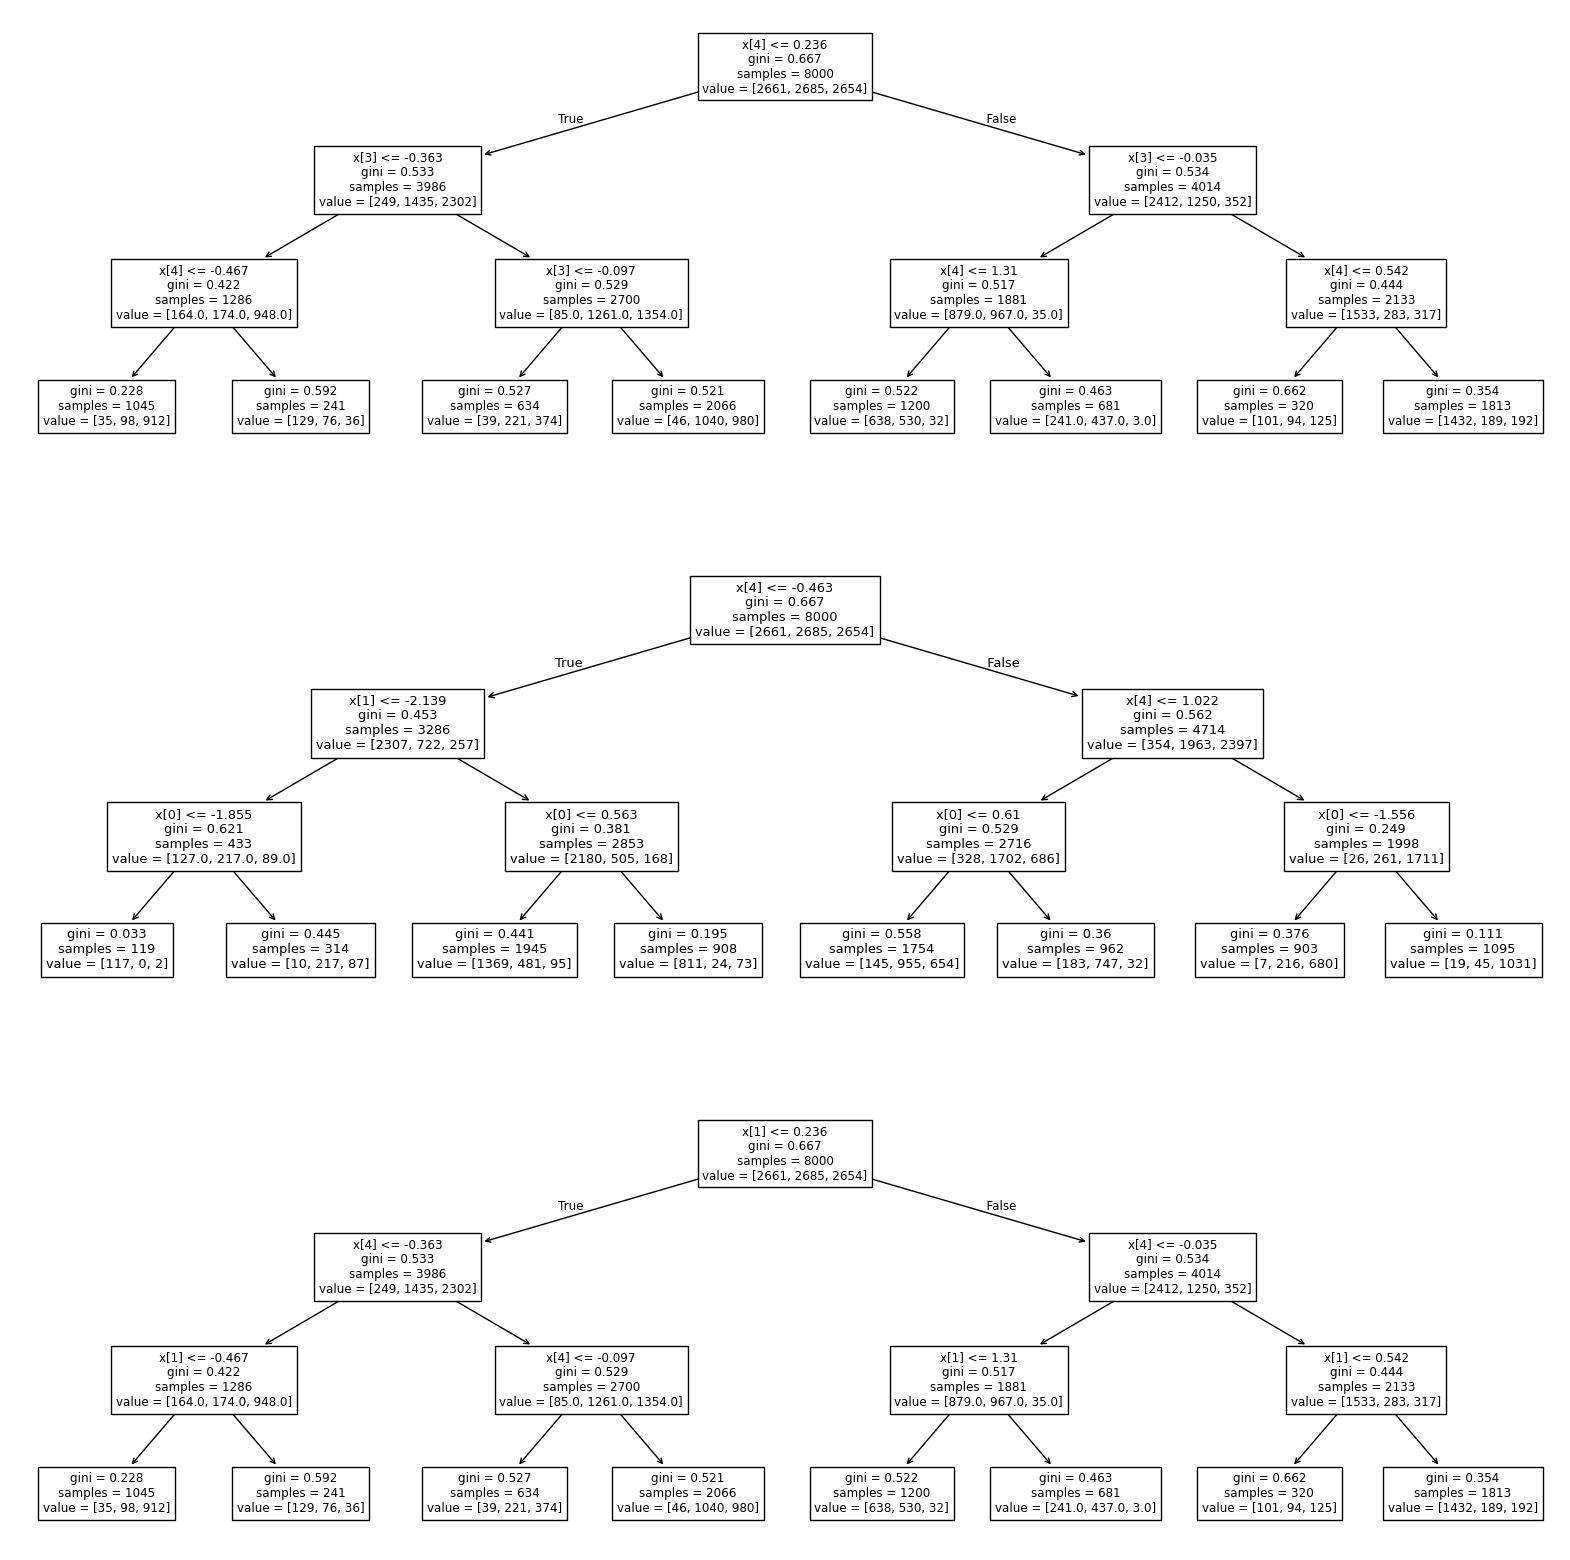

In [21]:
# Decision Tree for first three base estimators

fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(20, 20))
for idx, estimator in enumerate(rs.estimators_):
    if idx >= 3:
        break
    plot_tree(estimator, ax = ax[idx])
plt.show()

In [22]:
# Checking whether observations replaced or not - should not be replaced (Bagging)
f"Number of Duplicate rows used to train 1st base model: {len(rs.estimators_samples_[0]) - len(np.unique(rs.estimators_samples_[0]))}"

'Number of Duplicate rows used to train 1st base model: 0'

In [23]:
# Checking whether features replaced or not - should not be replaced ()
f"Number of Duplicate features used to train 1st base model: {len(rs.estimators_features_[0]) - len(np.unique(rs.estimators_features_[0]))}"

'Number of Duplicate features used to train 1st base model: 0'

In [24]:
# Evaluation
y_pred = rs.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1_score:", f1_score(y_test, y_pred, average="weighted"))

Accuracy: 0.7625
F1_score: 0.7597402668611135


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


### 4. Random Patches

*   **What it does:** **Samples *both* training instances *and* features.**
*   **How it creates diversity:** Each base model is trained on a random subset of the data points *and* a random subset of the features. It's a combination of Pasting and Random Subspaces.

In [25]:
rp = BaggingClassifier(
    # Estimator parameters
    estimator=DecisionTreeClassifier(
        # Generally, Low Variance models were used - to reduce overall variance
        max_depth = 3,
        random_state = 42
    ),
    n_estimators=50, 

    # Size Manipulation parameters
    max_samples=0.75, # Row sampling
    max_features=0.5, # Feature sampling

    # Sampling (with / without) replacement parameters
    bootstrap=False, # Row Sampling without replacement - (Random Patches Charastristic) 
    bootstrap_features=False, # Column Sampling without replacement - (Random Patches Charastristic)

    # Other parameters
    oob_score=False, # Out of bag estimation only available if bootstrap=True
    warm_start=False, # Trainig stated where it left off
    random_state=42,
    verbose=1
)

In [26]:
# Model Training
rp.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.2s finished


,estimator,DecisionTreeC...ndom_state=42)
,n_estimators,50
,max_samples,0.75
,max_features,0.5
,bootstrap,False
,bootstrap_features,False
,oob_score,False
,warm_start,False
,n_jobs,None
,random_state,42
,verbose,1


In [27]:
# Evaluation
y_pred = rp.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1_score:", f1_score(y_test, y_pred, average="weighted"))

Accuracy: 0.7545
F1_score: 0.7520444940086216


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


### Key Points on Bagging Classifier Voting
Here's a concise yet comprehensive breakdown of how bagging handles predictions, addressing your observation about hard/soft voting:

---

#### **1. Voting Mechanism in Bagging**  
- **Default Behavior (Hard Voting)**:  
  - Bagging classifiers aggregate final predictions via **majority vote** of base models' class labels.  
  - *Example*: With 100 decision trees:  
    - Class A: 60 votes, Class B: 40 votes → **Prediction = Class A**.  

- **No Explicit Soft Voting Parameter**:  
  - Unlike `VotingClassifier` in scikit-learn (which has `voting='soft'`), **`BaggingClassifier` has no built-in hyperparameter for soft voting**.  
  - *Reason*: Bagging focuses on **variance reduction** through parallel training, not probabilistic consensus.  

---

#### **2. Implicit Soft Voting via `predict_proba`**  
While bagging itself doesn’t support soft voting, you can access **probabilistic predictions**:  
- If base models implement `predict_proba` (e.g., decision trees):  
  ```python  
  # Returns averaged class probabilities across all base models  
  proba = bagging_model.predict_proba(X_test)  
  ```  
- **Final "soft" prediction** = Class with highest average probability.  
- *Interview Insight*:  
  > *"Bagging uses hard voting for `predict()`, but we can emulate soft voting via `predict_proba()`."*  

---

#### **3. Key Interview Considerations**  
| **Aspect**                | **Bagging Behavior**                                  |  
|---------------------------|-------------------------------------------------------|  
| **Voting Type**           | Hard voting (majority class) by default.              |  
| **Probabilities**         | Available via `predict_proba()` if base models support it. |  
| **Hyperparameter Control**| No explicit parameter to switch to soft voting.       |  
| **Random Forest Extension**| Uses soft voting internally (averages tree probabilities). |  

---

#### **4. Why Hard Voting Dominates in Bagging**  
- **Philosophy**:  
  - Bagging reduces **variance** by averaging diverse models. Hard voting is sufficient for this goal.  
- **Boosting Contrast**:  
  - Boosting (e.g., AdaBoost, GBM) uses weighted votes/probabilities to reduce **bias** iteratively.  

---

#### **5. Practical Workaround for Soft Voting**  
To force soft voting in bagging:  
```python  
from sklearn.ensemble import BaggingClassifier  
from sklearn.tree import DecisionTreeClassifier  

# Step 1: Train bagging with probability-enabled base estimator  
bagging = BaggingClassifier(  
    estimator=DecisionTreeClassifier(),  
    n_estimators=100  
)  
bagging.fit(X_train, y_train)  

# Step 2: Manually compute soft prediction  
proba = bagging.predict_proba(X_test)  
final_class = np.argmax(proba, axis=1)  
```